## Import TensorFlow and other libraries

In [1]:
# mount google drive to virtual machine using an authorization code

from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
import numpy as np

!pip install -U tensorboard

Requirement already up-to-date: tensorboard in /usr/local/lib/python3.6/dist-packages (2.2.1)


## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004) we apply random jittering and mirroring to the training dataset.

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [3]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30171136/30168306 [==============================] - 0s 0us/step


In [0]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [0]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

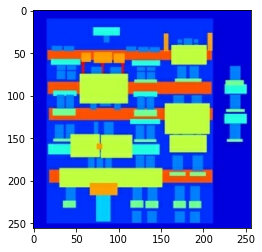

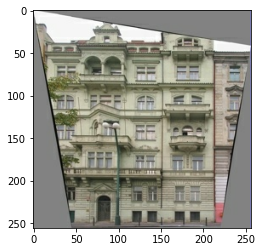

In [6]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [0]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [0]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [0]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [0]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

As you can see in the images below
that they are going through random jittering
Random jittering as described in the paper is to

1. Resize an image to bigger height and width
2. Randomly crop to the target size
3. Randomly flip the image horizontally

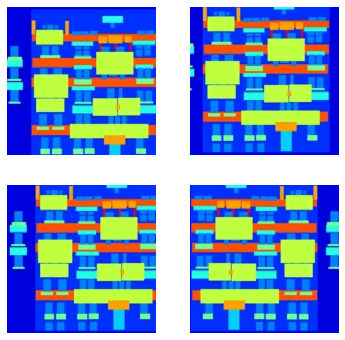

In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  #rj_inp, rj_re = inp, re
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [0]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  #input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [0]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Input Pipeline

In [0]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [0]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [0]:
OUTPUT_CHANNELS = 3

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [18]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)
print(inp.shape)

(1, 128, 128, 3)
(256, 256, 3)


In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [20]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [0]:
def Unet():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  
  x = inputs

  # Downsampling through the model
  skips = []
  downlayers = [[[]for i in range(len(down_stack)-1)]for j in range(len(down_stack)-1)]
  for i,down in enumerate(down_stack[:-1]):
    downlayers[i][0] = down(x)
    x = downlayers[i][0]
    for j in range(1,i+1):
        n = np.shape(downlayers[i][j-1])[1]
        y = upsample(n,4,apply_dropout=True)(downlayers[i][j-1])
        print(np.shape(y))
        downlayers[i][j] = tf.keras.layers.Concatenate()([y,downlayers[i-1][j-1]])
    
  skips = downlayers[-1][:]

  x = down_stack[-1](x)

  print(len(skips))
  print(len(up_stack))
  # skips = reversed(skips[:-1])
  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    print("x")
    print(np.shape(x))
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

(None, 128, 128, 64)
(None, 64, 64, 32)
(None, 128, 128, 64)
(None, 32, 32, 16)
(None, 64, 64, 32)
(None, 128, 128, 64)
(None, 16, 16, 8)
(None, 32, 32, 16)
(None, 64, 64, 32)
(None, 128, 128, 64)
(None, 8, 8, 4)
(None, 16, 16, 8)
(None, 32, 32, 16)
(None, 64, 64, 32)
(None, 128, 128, 64)
(None, 4, 4, 2)
(None, 8, 8, 4)
(None, 16, 16, 8)
(None, 32, 32, 16)
(None, 64, 64, 32)
(None, 128, 128, 64)
7
7
x
(None, 2, 2, 512)
x
(None, 4, 4, 512)
x
(None, 8, 8, 512)
x
(None, 16, 16, 512)
x
(None, 32, 32, 256)
x
(None, 64, 64, 128)
x
(None, 128, 128, 64)


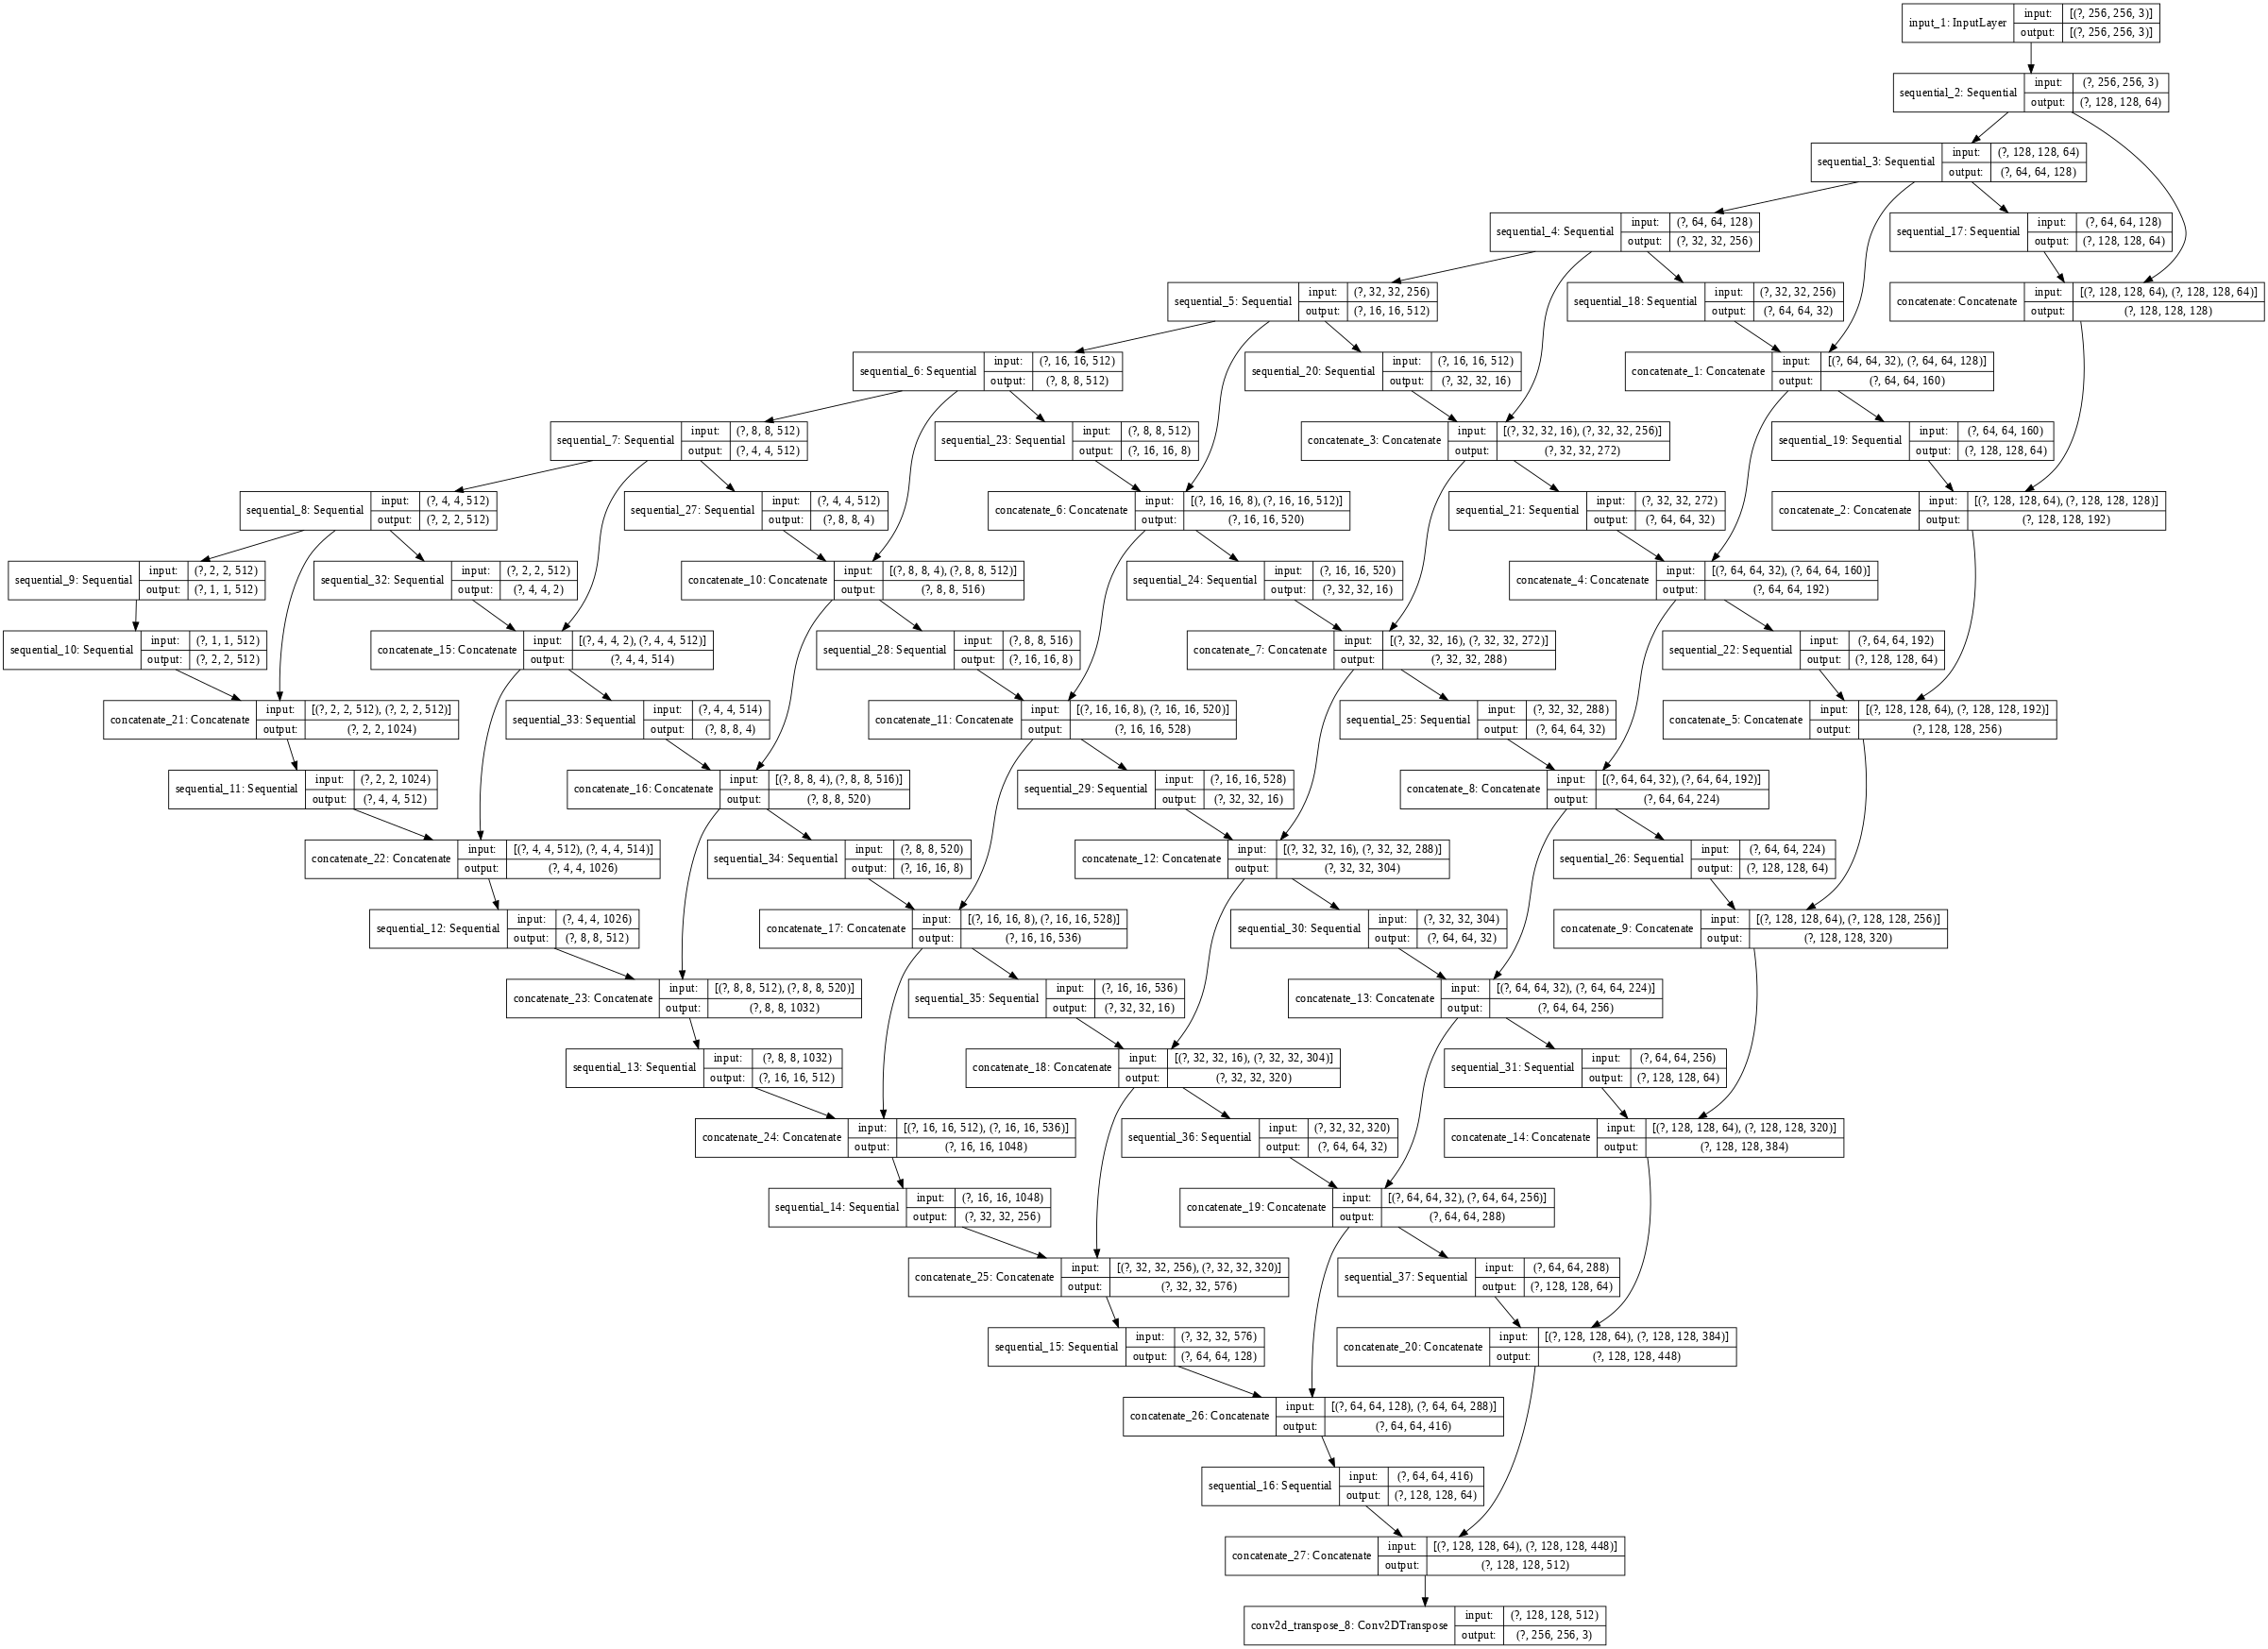

In [22]:
model = Unet()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


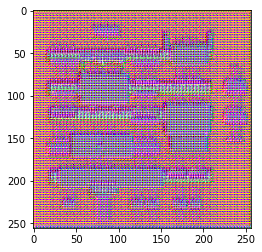

In [23]:
model_output = model(inp[tf.newaxis,...], training=False)
plt.imshow(model_output[0,...])

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [0]:
LAMBDA = 100

In [0]:
def model_loss(gen_output, target):
  # mean absolute error
  loss = tf.reduce_mean(tf.abs(target - gen_output))

  return loss

In [0]:
def model_loss(gen_output, target):
    im1 = gen_output*0.5+0.5
    im2 = target*0.5+0.5
    im1 = tf.image.convert_image_dtype(im1, tf.float32)
    im2 = tf.image.convert_image_dtype(im2, tf.float32)
    ssim = tf.image.ssim_multiscale(
      im1, im2, 1, filter_size=11,
      filter_sigma=1.5, k1=0.01, k2=0.03
      )
    return -ssim[0]

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


# Define optimizer and checkpoints

In [0]:
model_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=model_optimizer,
                                 model=model)

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)

In [0]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

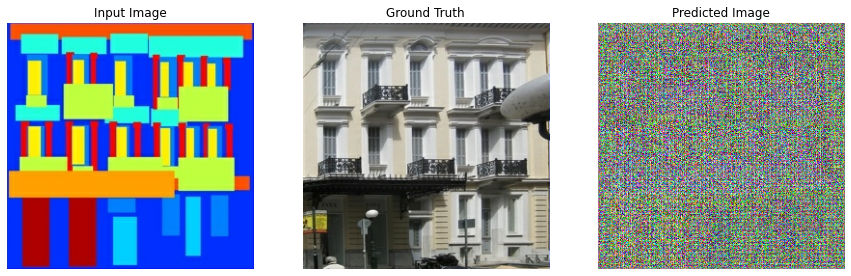

In [30]:
for example_input, example_target in test_dataset.take(1):
  generate_images(model, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [0]:
EPOCHS = 150

In [0]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [0]:
loss = 0

@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    img_output = model(input_image, training=True)

    loss = model_loss(img_output, target)

  model_gradients = gen_tape.gradient(loss,
                                          model.trainable_variables)

  model_optimizer.apply_gradients(zip(model_gradients,
                                          model.trainable_variables))
  
  with summary_writer.as_default():
    tf.summary.scalar('Model loss', loss, step=epoch)

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [0]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()
  
    display.clear_output(wait=True)

    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      for example_input, example_target in test_ds.take(1):
        generate_images(model, example_input, example_target)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [0]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 373), started 2:29:22 ago. (Use '!kill 373' to kill it.)

<IPython.core.display.Javascript object>

Now run the training loop:

Epoch:  199
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................



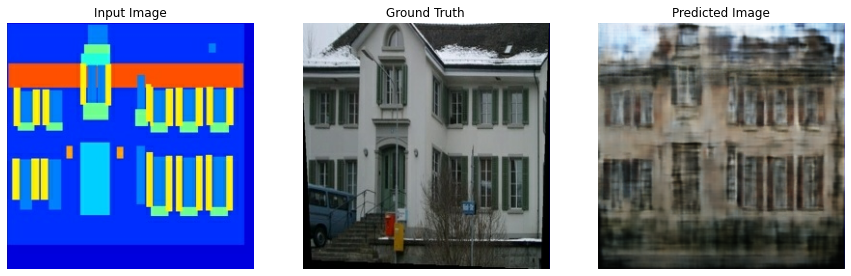

Time taken for epoch 200 is 29.463680267333984 sec



In [0]:
fit(train_dataset, 200, test_dataset)

In [0]:
# path = "drive/My Drive/DLOI Project"
# model.save_weights(path + "/unetpp.h5")


In [0]:
path = "drive/My Drive/DLOI Project"
model.load_weights(path + "/unetpp.h5")


In [0]:
test_input = []
test_output = []
generated_image = []
for example_input, example_target in test_dataset.take(105):
  test_input.append(example_input) 
  test_output.append(example_target)
  generated_image.append(model(example_input, training=True))

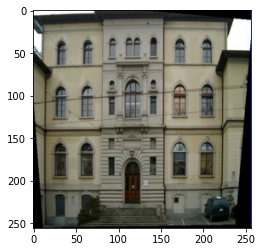

In [37]:
plt.imshow(test_output[3][0]*0.5+0.5)

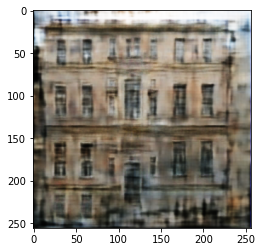

In [38]:
plt.imshow(generated_image[3][0]*0.5+0.5)

In [39]:
import numpy as np
import numpy.linalg as lg
# mean ssim
loss_ssim = 0
for i in range(105):
    im1 = test_output[i][0]*0.5+0.5
    im2 = generated_image[i][0]*0.5+0.5

    # Compute SSIM over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(im1, tf.float32)
    im2 = tf.image.convert_image_dtype(im2, tf.float32)
    ssim = tf.image.ssim_multiscale(
          im1, im2, 1, filter_size=11,
          filter_sigma=1.5, k1=0.01, k2=0.03
          )
    # ssim1 and ssim2 both have type tf.float32 and are almost equal.
    loss_ssim += ssim.numpy()
loss_ssim = loss_ssim / 105
loss_ssim

0.3430929650508222

In [40]:
# mean square error
loss_mse = 0
for i in range(105):
    im1 = test_output[i][0].numpy().transpose(2,0,1).reshape(3,-1)
    im2 = generated_image[i][0].numpy().transpose(2,0,1).reshape(3,-1)
    loss_mse += lg.norm(im1-im2)**2
loss_mse = loss_mse / 105
loss_mse

46465.29215719406

In [41]:
# mean abusolute error
loss_mae = 0
for i in range(105):
    im1 = test_output[i][0].numpy().transpose(2,0,1).reshape(3,-1)
    im2 = generated_image[i][0].numpy().transpose(2,0,1).reshape(3,-1)
    loss_mae += lg.norm(im1-im2,1)
loss_mae = loss_mae / 105
loss_mae

5.40929488227481

In [0]:
import numpy as np
import numpy.linalg as lg
from skimage.measure import compare_ssim as ssim

loss_ssim = 0
for example_input, example_target in test_dataset.take(100):
    im1 = example_target[0].numpy()
    im2 = model(example_input,training=False)[0].numpy()
    s=ssim(im1,im2,multichannel=True)
    loss_ssim += s
loss_ssim /= 100
print(loss_ssim)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  if __name__ == '__main__':


0.08546302203272838


In [0]:
loss_mse = 0
for example_input, example_target in test_dataset.take(100):
    im1 = example_target[0].numpy()
    im2 = model(example_input,training=False)[0].numpy()
    loss_mse += lg.norm(im1-im2)**2
loss_mse /= 100
print(loss_mse)

46176.40129929665


In [0]:
loss_mae = 0
for example_input, example_target in test_dataset.take(100):
    im1 = example_target[0].numpy()
    im2 = model(example_input,training=False)[0].numpy()
    loss_mae += tf.math.reduce_mean(tf.math.abs(im1-im2))
loss_mae /= 100
print(loss_mae)

tf.Tensor(0.3688966, shape=(), dtype=float32)


If you want to share the TensorBoard results _publicly_ you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir  {log_dir}
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

In [0]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

Interpreting the logs from a GAN is more subtle than a simple classification or regression model. Things to look for::

* Check that neither model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
* The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2: That the discriminator is on average equally uncertain about the two options.
* For the `disc_loss` a value below `0.69` means the discriminator is doing better than random, on the combined set of real+generated images.
* For the `gen_gan_loss` a value below `0.69` means the generator i doing better than random at foolding the descriminator.
* As training progresses the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test

In [0]:
!ls {checkpoint_dir}

checkpoint		     ckpt-5.data-00000-of-00002
ckpt-10.data-00000-of-00002  ckpt-5.data-00001-of-00002
ckpt-10.data-00001-of-00002  ckpt-5.index
ckpt-10.index		     ckpt-6.data-00000-of-00002
ckpt-1.data-00000-of-00002   ckpt-6.data-00001-of-00002
ckpt-1.data-00001-of-00002   ckpt-6.index
ckpt-1.index		     ckpt-7.data-00000-of-00002
ckpt-2.data-00000-of-00002   ckpt-7.data-00001-of-00002
ckpt-2.data-00001-of-00002   ckpt-7.index
ckpt-2.index		     ckpt-8.data-00000-of-00002
ckpt-3.data-00000-of-00002   ckpt-8.data-00001-of-00002
ckpt-3.data-00001-of-00002   ckpt-8.index
ckpt-3.index		     ckpt-9.data-00000-of-00002
ckpt-4.data-00000-of-00002   ckpt-9.data-00001-of-00002
ckpt-4.data-00001-of-00002   ckpt-9.index
ckpt-4.index


In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate using test dataset

In [0]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(model, inp, tar)

NameError: ignored